In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [2]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader

Git root path found at: C:\dev\grid-analysis
Using data path:        C:\dev\grid-analysis\data


In [3]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [60]:
sgn = SciGRID_network("")

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network scigrid-with-load-gen-trafos has buses, generators, lines, loads, storage_units, transformers


0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [5]:
month_index = 0
month_name = ARMAfit_loader.monthnames[month_index]

solar_res_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_resdaylightcov.npy")
wind_res_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_rescov.npy")
solar_gen_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_gendaylightcov.npy")
wind_gen_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_gencov.npy")
solar_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcov.npy")
wind_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcov.npy")

In [6]:
bus_res_cov_day = wind_res_cov + solar_res_cov
bus_res_cov_night = wind_res_cov
bus_gen_cov_day = wind_gen_cov + solar_gen_cov
bus_gen_cov_night = wind_gen_cov
bus_diff_cov_day = wind_diff_cov + solar_diff_cov
bus_diff_cov_night = wind_diff_cov

bus_res_cov_solar = solar_res_cov
bus_gen_cov_solar = solar_gen_cov
bus_diff_cov_solar = solar_diff_cov

In [7]:
line_res_cov_day = sgn.F @ bus_res_cov_day @ sgn.F.T
line_res_cov_night = sgn.F @ bus_res_cov_night @ sgn.F.T
line_gen_cov_day = sgn.F @ bus_gen_cov_day @ sgn.F.T
line_gen_cov_night = sgn.F @ bus_gen_cov_night @ sgn.F.T
line_diff_cov_day = sgn.F @ bus_diff_cov_day @ sgn.F.T
line_diff_cov_night = sgn.F @ bus_diff_cov_night @ sgn.F.T

line_res_cov_solar = sgn.F @ bus_res_cov_solar @ sgn.F.T
line_gen_cov_solar = sgn.F @ bus_gen_cov_solar @ sgn.F.T
line_diff_cov_solar = sgn.F @ bus_diff_cov_solar @ sgn.F.T

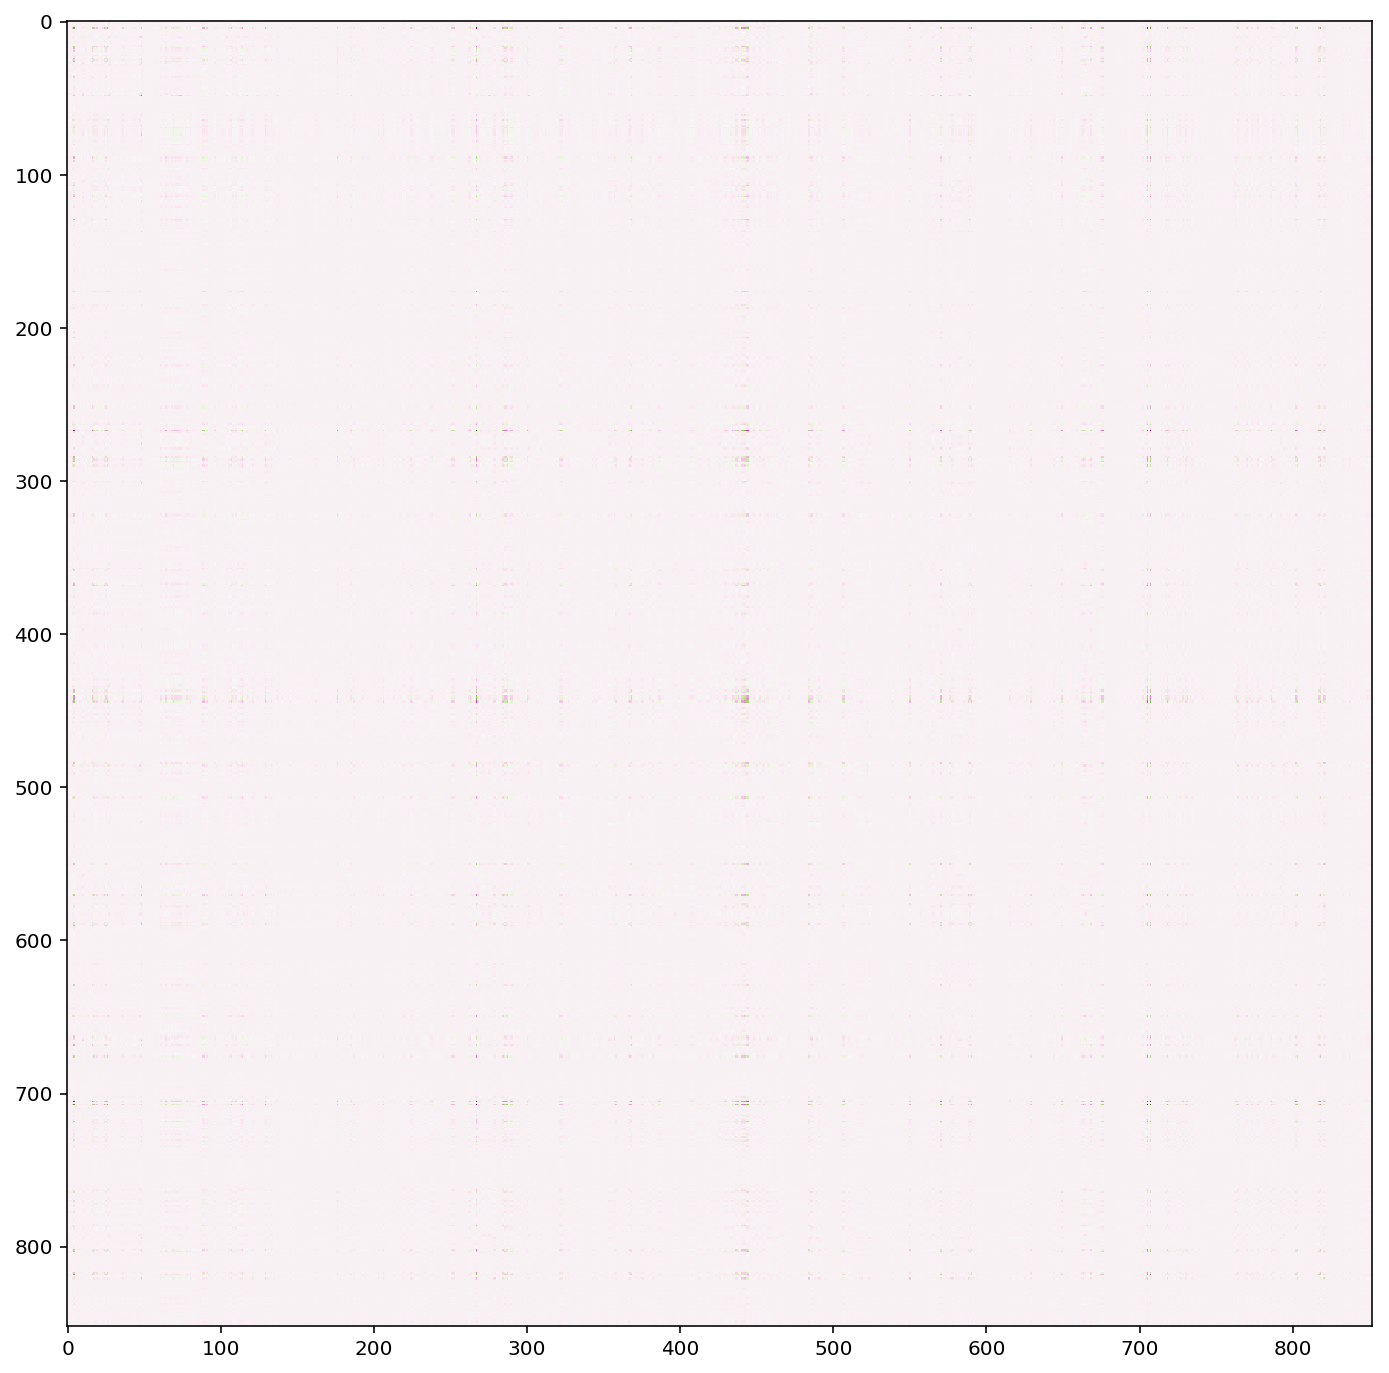

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(line_gen_cov_day, cmap="PiYG")

In [9]:
sgn.network.generators.p_nom.describe()

count    1.423000e+03
mean     1.212513e+02
std      2.833683e+02
min      2.147047e-08
25%      1.117244e+01
50%      3.872489e+01
75%      1.075388e+02
max      4.730000e+03
Name: p_nom, dtype: float64

In [10]:
des = lambda x: pd.Series(x).describe()

des(np.sqrt(np.diagonal(line_diff_cov_day)))

count    852.000000
mean      42.136190
std       48.974580
min        0.110106
25%        8.758967
50%       22.040452
75%       60.075983
max      433.210799
dtype: float64

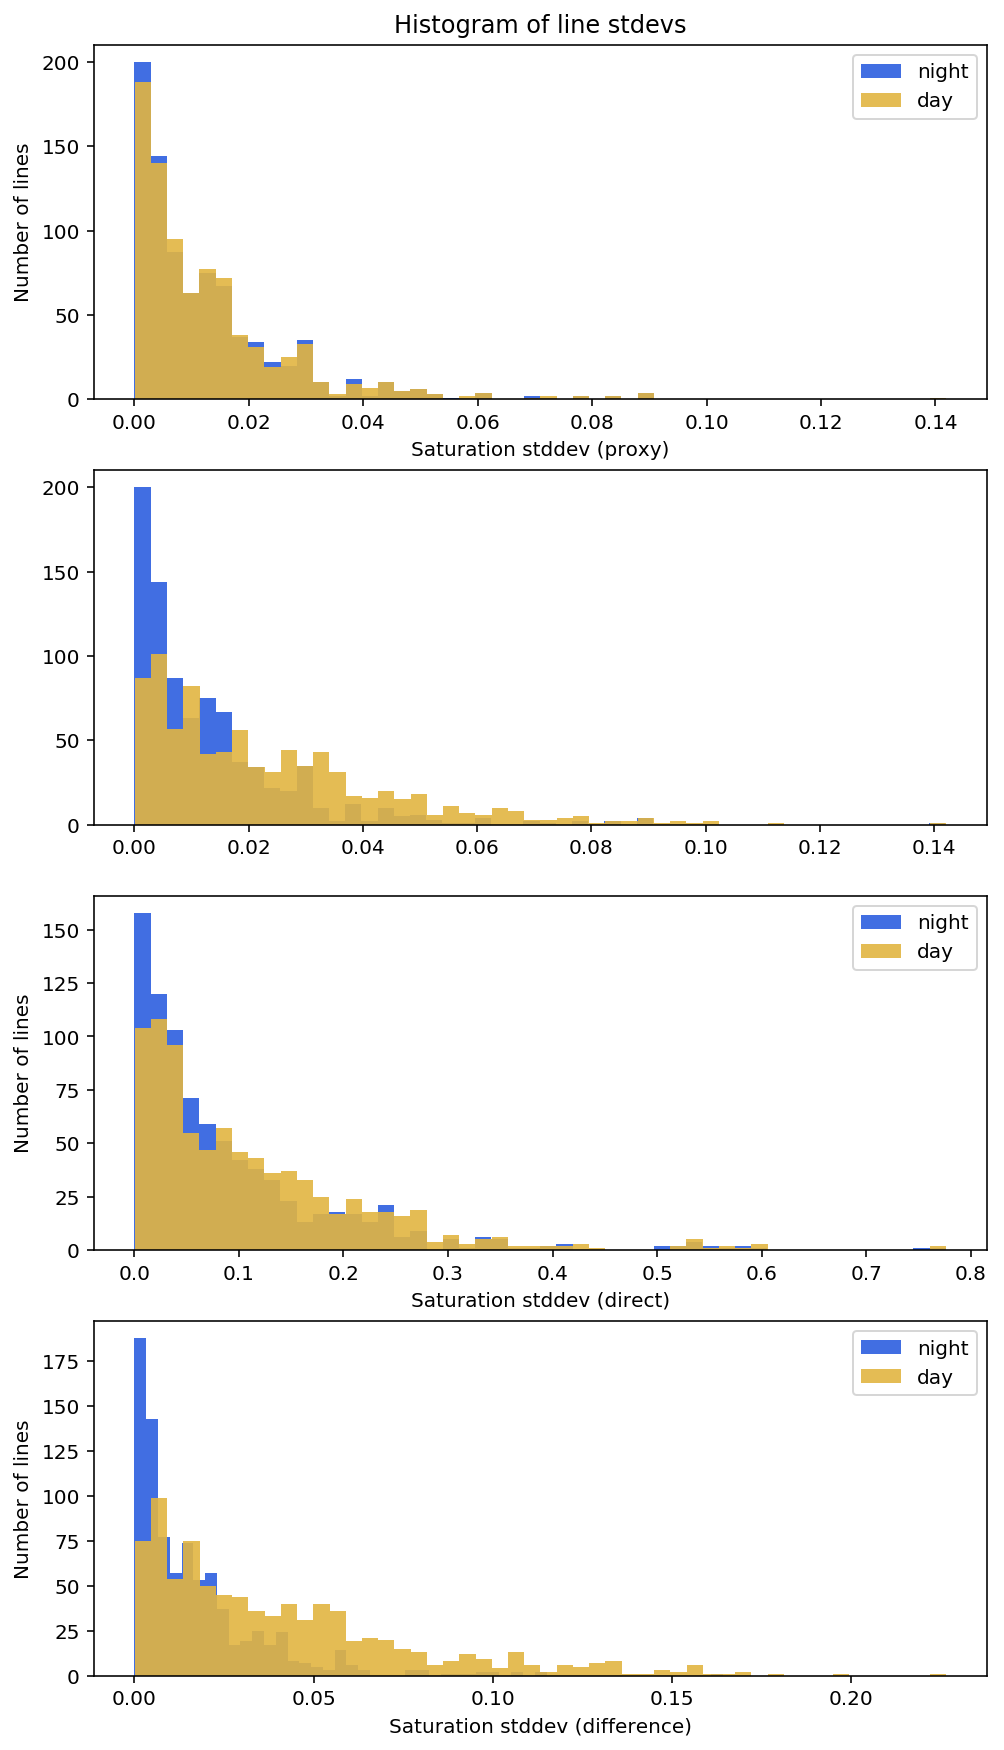

In [12]:
fig, ax = plt.subplots(4,1,figsize=(8,15))
#plt.subplots_adjust(hspace=.3)

ax[0].hist(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_capacity, bins=50, color=src.globals.wind_color, label="night")
ax[0].hist(np.sqrt(np.diagonal(line_res_cov_day)) / sgn.line_capacity, bins=50, color=src.globals.solar_color, label="day", alpha=.9)

ax[1].hist(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_capacity, bins=50, color=src.globals.wind_color, label="night")
ax[1].hist(np.sqrt(np.diagonal(line_res_cov_night + 0.1 * line_gen_cov_solar)) / sgn.line_capacity, bins=50, color=src.globals.solar_color, label="day", alpha=.9)

ax[2].hist(np.sqrt(np.diagonal(line_gen_cov_night)) / sgn.line_capacity, bins=50, color=src.globals.wind_color, label="night")
ax[2].hist(np.sqrt(np.diagonal(line_gen_cov_day)) / sgn.line_capacity, bins=50, color=src.globals.solar_color, label="day", alpha=.9)

ax[3].hist(np.sqrt(np.diagonal(line_diff_cov_night)) / sgn.line_capacity, bins=50, color=src.globals.wind_color, label="night")
ax[3].hist(np.sqrt(np.diagonal(line_diff_cov_day)) / sgn.line_capacity, bins=50, color=src.globals.solar_color, label="day", alpha=.9)



ax[0].set_title("Histogram of line stdevs")
ax[0].set_xlabel("Saturation stddev (proxy)")
ax[0].set_ylabel("Number of lines")
ax[0].legend()

#ax[2].set_title("Histogram of line stdevs (direct)")
ax[2].set_xlabel("Saturation stddev (direct)")
ax[2].set_ylabel("Number of lines")
ax[2].legend()

#ax[3].set_title("Histogram of line stdevs (difference)")
ax[3].set_xlabel("Saturation stddev (difference)")
ax[3].set_ylabel("Number of lines")
ax[3].legend()

In [13]:
describeshort = lambda series: printm("|range | mean | \n |---|---| \n | $[{0:.6f},{1:.6f}]$ | ${2:.4f}$ |".format(np.min(series), np.max(series), np.mean(series)))

printm("# Proxy")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_res_cov_day)) / sgn.line_capacity)
printm("_Alt 1_: Night residues, 25% differences")
describeshort((np.sqrt(np.diagonal(line_res_cov_night) + .25*np.diagonal(line_diff_cov_solar))) / sgn.line_capacity)
printm("_Alt 2_: Night residues, 10% direct")
describeshort((np.sqrt(np.diagonal(line_res_cov_night) + .1*np.diagonal(line_gen_cov_solar))) / sgn.line_capacity)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_capacity)

printm("# Direct")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_gen_cov_day)) / sgn.line_capacity)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_gen_cov_night)) / sgn.line_capacity)

printm("# Differences")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_diff_cov_day)) / sgn.line_capacity)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_diff_cov_night)) / sgn.line_capacity)

# Proxy

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000022,0.141859]$ | $0.0133$ |

_Alt 1_: Night residues, 25% differences

|range | mean | 
 |---|---| 
 | $[0.000058,0.142089]$ | $0.0232$ |

_Alt 2_: Night residues, 10% direct

|range | mean | 
 |---|---| 
 | $[0.000048,0.142088]$ | $0.0231$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000013,0.141857]$ | $0.0130$ |

# Direct

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000177,0.776427]$ | $0.1130$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000100,0.776005]$ | $0.0912$ |

# Differences

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000111,0.226463]$ | $0.0405$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000017,0.164237]$ | $0.0167$ |

In [14]:

armafits = ARMAfit_loader(sgn)

In [15]:
printm("Average national solar generation: {0:.0f} MW".format(armafits.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits.wind_generationmonth.sum(axis=0).mean()))

Average national solar generation: 3170 MW

Average national wind generation: 10805 MW

# 🌼

In [75]:
sgn2= SciGRID_network(Path(pypsapath + "/examples/scigrid-de/scigrid-with-load-gen-trafos/"))

sgn2.run_lopf_jan1()

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network scigrid-with-load-gen-trafos has buses, generators, lines, loads, storage_units, transformers
INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


0.13.2 ['C:/dev/py/PyPSA\\pypsa']
Performing linear OPF for one day, 4 snapshots at a time:


INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1449687.2501478
  Upper bound: 1449687.2501478
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.9794116020202637
# ----------------------------------------------------------
#   Solution Information
# ------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 873763.90232936
  Upper bound: 873763.90232936
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.724604845046997
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 790786.594882226
  Upper bound: 790786.594882226
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 6.452867031097412
# ----------------------------------------------------------
#   Solution Information
# -----

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1455232.6782739
  Upper bound: 1455232.6782739
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 4.425879001617432
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2647879.91201594
  Upper bound: 2647879.91201594
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.2902655601501465
# ----------------------------------------------------------
#   Solution Information
# ----

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2139360.37637067
  Upper bound: 2139360.37637067
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.4766619205474854
# ----------------------------------------------------------
#   Solution Information
# ----

In [82]:
#pd.Series(sgn2.line_saturation_total.values[11])
#sgn2.network.lines_t.p1.values[11]# / sgn2.network.lines.s_nom
sgn2.line_flow_total

,0,1,2,3,4,5,6,7,8,9,...,842,843,844,845,846,847,848,849,850,851
name,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,-53.139861,613.833899,417.719214,-902.940712,1138.265615,33.462716,54.085193,49.714701,-41.612151,-57.107223,...,136.467304,461.057156,153.274058,2050.626099,97.385649,100.009169,182.189955,273.771752,56.213741,288.440371
2011-01-01 01:00:00,-50.880496,699.487857,416.454602,-961.504915,1068.336433,13.426583,42.474190,33.861733,-30.341094,-39.177869,...,129.332505,457.926036,142.239068,2048.835196,100.584586,99.558555,182.013845,272.514691,55.514605,281.575538
2011-01-01 02:00:00,-48.894821,726.150730,404.914333,-976.503741,984.167538,7.488931,41.416923,30.760348,-37.389370,-51.317063,...,123.583376,445.273616,109.345223,2047.244934,113.500951,104.012414,191.661356,269.457608,57.224726,301.529202
2011-01-01 03:00:00,-48.338753,747.175213,415.217527,-1021.907038,1102.377560,2.391428,38.015430,26.427380,-44.809698,-64.170415,...,122.201247,433.202318,104.896116,2045.364205,125.272780,109.236241,202.409943,277.438709,59.521281,326.062206
2011-01-01 04:00:00,-45.822233,733.698585,380.162872,-966.567724,796.296331,0.643411,41.449301,28.022908,-47.636968,-68.768880,...,114.958824,421.970117,78.729861,2045.043159,120.043582,104.270139,194.086961,263.519729,56.699177,315.124401
2011-01-01 05:00:00,-42.553846,707.193859,355.423504,-936.531743,664.978261,-23.573720,23.773279,6.422292,-68.065973,-103.898249,...,105.462506,360.110253,53.950675,2042.385234,114.571808,98.478762,184.539986,260.443038,53.649892,305.244530
2011-01-01 06:00:00,-42.728357,739.230492,370.200665,-971.399781,793.708454,-21.575350,24.477534,7.699471,-73.237501,-112.906004,...,106.644550,359.575720,46.304838,2042.036064,115.106881,98.916661,187.516146,255.879574,55.351797,304.605165
2011-01-01 07:00:00,-43.388981,731.352354,368.742759,-966.180824,779.747936,-8.481985,35.620010,20.440285,-74.157142,-114.521094,...,107.934010,357.656231,49.700129,2042.608853,119.829072,101.833490,191.409059,239.281553,55.942459,313.702148
2011-01-01 08:00:00,-45.987400,782.815599,394.774220,-998.220533,943.891119,11.474601,48.248233,36.942545,-58.612011,-97.027812,...,114.943600,379.779721,85.388328,1834.141563,128.623110,108.580828,202.722405,220.397692,59.089546,328.325511


In [77]:
f = sgn2.line_saturation_total.values[11,:]

def true_prob(mu, sigma):
    return 1.0 - (scipy.stats.norm.cdf(1.0, loc=mu, scale=sigma) - scipy.stats.norm.cdf(-1.0, loc=mu, scale=sigma))

def rate(mu, sigma):
    return np.square(1-np.abs(mu))/(2.0*np.square(sigma))

line_ratings = pd.DataFrame({"l":1+np.arange(sgn2.m),
              "f": f,
              "σres_day": np.sqrt(np.diagonal(line_res_cov_day)) / sgn2.line_capacity,
              "σalt1_day": (np.sqrt(np.diagonal(line_res_cov_night) + .25*np.diagonal(line_diff_cov_solar))) / sgn2.line_capacity,
              "σgen_day": np.sqrt(np.diagonal(line_gen_cov_day)) / sgn2.line_capacity,
              "σdiff_day": np.sqrt(np.diagonal(line_diff_cov_day)) / sgn2.line_capacity})

line_ratings["P>1"] = true_prob(line_ratings.f, line_ratings.σdiff_day)

sgn2.line_flow_total.values[11,:]

array([-1.30514126e+01,  7.78700534e+02,  4.67614492e+02, -1.02360892e+03,
        1.17206891e+03,  1.67327039e+01,  3.43136443e+01,  2.97281871e+01,
       -2.38335776e+01, -3.32534504e+01,  1.44607665e+03, -8.81571140e+01,
        2.90546834e+01, -3.32174772e+01,  5.45065070e+01,  8.85803989e+01,
        4.03129839e+02, -5.15668283e+02,  1.32898945e+02, -2.40023228e+02,
        8.01178566e+01, -5.39125821e+02,  2.87147314e+02, -2.94174863e+02,
        2.09078848e+02,  5.80090577e+02, -6.22005285e+02, -1.30353146e+03,
        1.26506691e+03,  9.83519153e+01,  4.45117190e+01, -2.94234968e+02,
       -2.90031423e+02,  3.99371212e+02, -2.94818161e+02, -2.40927658e+02,
       -1.43728950e+02, -3.88693518e+01,  2.19953201e+02, -1.38477280e+02,
       -1.38633297e+02, -6.35870214e+01, -3.87970514e+01, -2.89063395e+02,
       -2.88740874e+02,  9.99306187e+01, -8.86774581e+01, -1.32616631e+03,
        2.42630370e+03,  1.39809446e+02, -7.09281841e+02,  1.00024037e+02,
       -8.90374723e+01, -

In [73]:
elevenAM = sgn2.network.generators_t.p.index[11]


power_injection = np.zeros(sgn2.n)

for generator_name, generation in sgn2.network.generators_t.p.loc[elevenAM,:].iteritems():
    generator_bus = sgn2.network.generators.bus[generator_name]
    power_injection[sgn2.node_index(generator_bus)] += generation# / network.buses.voltage[generator_bus]

for bus_name, load in sgn2.network.loads_t.p_set.loc[elevenAM,:].iteritems():
    power_injection[sgn2.node_index(bus_name)] -= load

pd.Series(power_injection).describe()

flow = sgn2.F.dot(power_injection)

print(f"Total load: {sgn2.network.loads_t.p_set.loc[elevenAM,:].sum()} MW")
print(f"Total generation: {sgn2.network.generators_t.p.loc[elevenAM,:].sum()} MW")
print(f"Generation overshoot: {power_injection.sum()} MW")

power_injection

Total load: 52524.64000000082 MW
Total generation: 52589.76674893871 MW
Generation overshoot: 65.12674893788744 MW


array([-1.53724693e+02,  1.97079113e+01,  3.26636884e+02,  2.09377387e+02,
       -1.35435987e+02, -8.12861394e+01, -5.63292984e+01, -6.21165653e+01,
       -3.38608968e+01,  6.31348791e+00, -3.77553179e+01,  3.63223095e+02,
        5.07547860e+01, -2.07695326e+01,  9.51580599e+01, -3.34669662e+01,
       -7.00917817e+01, -5.99029987e+01,  9.43120128e+02, -1.10850756e+02,
       -9.62735440e+01, -1.57210801e+02, -4.79413142e+00, -8.92381429e+01,
       -1.03980834e+01, -1.31842907e+01,  8.12271320e+02, -3.82007022e+01,
       -8.48129604e+01, -2.06471453e+02,  1.19788634e+03, -5.10948729e+01,
       -4.41816032e+01,  2.21520501e+02, -1.78351067e+02, -4.90767104e+01,
       -9.87888331e+01,  1.27933408e+02,  7.58843936e+01, -3.37561513e+01,
       -3.12774194e+01,  2.67365157e+00, -4.46838532e+01, -6.41586795e+01,
       -2.79572536e+00, -1.31239352e+02, -4.33683288e+01, -5.30593950e+01,
       -5.78054231e+01, -4.43997001e+01, -5.35017436e+01,  4.46096081e+01,
       -2.00923740e+02, -

(array([107.,  62.,  67.,  50.,  50.,  40.,  29.,  41.,  34.,  23.,  35.,
         22.,  25.,  24.,  14.,  18.,  25.,  16.,  11.,  13.,  11.,   5.,
         14.,   9.,   7.,  16.,   4.,   3.,  10.,   8.,   2.,   4.,   2.,
          4.,   5.,   3.,   6.,   3.,  18.,   6.,   3.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([7.31656109e-05, 2.59247028e-02, 5.17762399e-02, 7.76277771e-02,
        1.03479314e-01, 1.29330851e-01, 1.55182389e-01, 1.81033926e-01,
        2.06885463e-01, 2.32737000e-01, 2.58588537e-01, 2.84440074e-01,
        3.10291612e-01, 3.36143149e-01, 3.61994686e-01, 3.87846223e-01,
        4.13697760e-01, 4.39549297e-01, 4.65400834e-01, 4.91252372e-01,
        5.17103909e-01, 5.42955446e-01, 5.68806983e-01, 5.94658520e-01,
        6.20510057e-01, 6.46361595e-01, 6.72213132e-01, 6.98064669e-01,
        7.23916206e-01, 7.49767743e-01, 7.75619280e-01, 8.01470818e-01,
        8.27322355e-01, 8.53173892e-01, 8.79025429e-01, 9.04876966e-01,
        9.

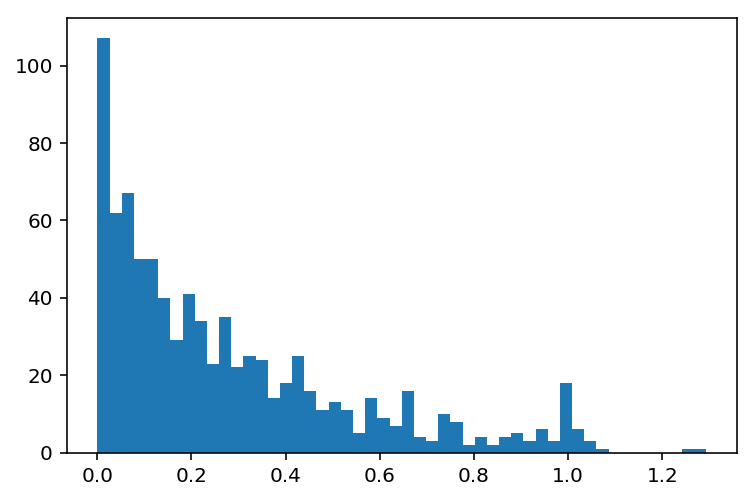

In [71]:
fig, ax = plt.subplots()

ax.hist(np.abs(sgn2.F @ power_injection / sgn2.line_capacity), bins=50)

In [70]:
line_ratings.sort_values("P>1")

,l,f,σres_day,σalt1_day,σgen_day,σdiff_day,P>1
0,1,-0.037639,0.011159,0.012466,0.039265,0.017037,0.000000
514,515,0.235922,0.012063,0.046718,0.164573,0.091689,0.000000
520,521,0.003373,0.000821,0.003519,0.013007,0.006948,0.000000
521,522,0.003388,0.000824,0.003534,0.013063,0.006978,0.000000
522,523,-0.097587,0.004491,0.031042,0.110247,0.061801,0.000000
525,526,-0.136363,0.003466,0.012515,0.041080,0.024763,0.000000
526,527,-0.184994,0.001476,0.005865,0.018397,0.011614,0.000000
527,528,-0.268970,0.005685,0.012459,0.051422,0.023425,0.000000
528,529,-0.122666,0.002540,0.005662,0.023562,0.010676,0.000000
529,530,-0.307765,0.005406,0.014380,0.063579,0.027717,0.000000
